RQ2 – Agentic PR Complexity Across Languages
Do Coding Agents create PRs that remain open longer or undergo more reviewer interaction in some languages compared to others?

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# pr_df has information about each Pull Request (Pr)
# repodf has the repo language (Python, Rest,...)
# user_df has information about who reated PR
# comments_df has all PR comments
# reviews_df has PR review activities

pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")
comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
reviews_df  = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")

#pr_df.head()
#repo_df.head()
#user_df.head()
#comments_df.head()
#reviews_df.head()

In [15]:
# adding repo.language
# adding user.login
# to avoid suplicates we are using suffixes
merged = (
    pr_df.merge(
        repo_df[["id", "language"]],
        left_on="repo_id",
        right_on="id",
        how="left"
    )
    .merge(
        user_df[["id", "login"]],
        left_on="user_id",
        right_on="id",
        how="left",
        suffixes=("", "_user")
    )
)

# drop PRs with missing language
merged = merged.dropna(subset=["language"])

merged.head()

,id_x,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,id_y,language,id,login
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911,191751505,Python,108661493.0,weiliu1031
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2,1025472321,TypeScript,61827001.0,cm-kojimat
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30,988488798,Swift,7475.0,MSch
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,999285986,TypeScript,80381.0,sugyan
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625,537233603,Rust,47593288.0,adust09


In [16]:
def convert_agent(x):
    x=str(x).lower().strip()
    # list to represent agent
    agent_values = ["true","t","yes","y","agent","ai","1"]
    if x in agent_values:
        return 1
    else:
        return 0
merged["agent_num"]=merged["agent"].apply(convert_agent)
#merged.head()

In [17]:
# to convert timestamps to date times 
merged["created_at"]=pd.to_datetime(merged["created_at"])
merged["closed_at"]=pd.to_datetime(merged["closed_at"])
merged["merged_at"]=pd.to_datetime(merged["merged_at"])

# next we try to add closed_at and if not present (NaN) then merged_at
merged["end_time"]=merged["closed_at"].combine_first(merged["merged_at"])

# this is used to determine how long PR lasts
merged["pr_lifetime_hours"]=(merged["end_time"] - merged["created_at"]).dt.total_seconds()/3600

# we'll remove PRs where the time duration could not be calculated
merged=merged.dropna(subset=["pr_lifetime_hours"])
merged.head()

,id_x,number,title,body,agent,user_id,user,state,created_at,closed_at,...,repo_id,repo_url,html_url,id_y,language,id,login,agent_num,end_time,pr_lifetime_hours
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26 02:59:01+00:00,2025-07-29 07:01:20+00:00,...,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911,191751505,Python,108661493.0,weiliu1031,0,2025-07-29 07:01:20+00:00,76.038611
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,...,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2,1025472321,TypeScript,61827001.0,cm-kojimat,0,2025-07-26 22:12:24+00:00,17.258056
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,...,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30,988488798,Swift,7475.0,MSch,0,2025-07-26 13:37:22+00:00,0.100833
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,...,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,999285986,TypeScript,80381.0,sugyan,0,2025-07-26 14:45:30+00:00,0.635556
16,3234102722,318,chore: Convert hive-mind coordination system t...,## Summary\n\nThis PR converts the AI agent co...,Claude_Code,15803865,lanemc,closed,2025-07-16 01:00:34+00:00,2025-07-17 12:49:29+00:00,...,995029641,https://api.github.com/repos/ruvnet/claude-flow,https://github.com/ruvnet/claude-flow/pull/318,995029641,TypeScript,15803865.0,lanemc,0,2025-07-17 12:49:29+00:00,35.815278


In [18]:
# combine title + body length
merged["text_length"] = (
    merged["title"].fillna("").str.len() +
    merged["body"].fillna("").str.len()
)

# number of PRs per user
# Used Ai to determine how to fix this problem because my mistake was that I created a variable 
# named use_activity, but then tried to merge a different variable named user_activity, 
# which does not exist.
user_activity = (
    merged.groupby("user_id")
          .size()
          .rename("user_total_prs")
          .reset_index()
)

# merge user activity into main table
merged = merged.merge(user_activity, on="user_id", how="left")

# to determine the number of commits per PR
comment_count = (
    comments_df.groupby("pr_id").size().rename("num_comments")
)
# to determine the number of reviews per PR
review_count=(
    reviews_df.groupby("pr_id").size().rename("num_reviews")
)
merged=merged.merge(comment_count,left_on="id",right_index=True,how="left")
merged=merged.merge(review_count,left_on="id",right_index=True,how="left")
merged["num_comments"]=merged["num_comments"].fillna(0)
merged["num_reviews"]=merged["num_reviews"].fillna(0)
merged.head()

,id_x,number,title,body,agent,user_id,user,state,created_at,closed_at,...,language,id,login,agent_num,end_time,pr_lifetime_hours,text_length,user_total_prs,num_comments,num_reviews
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26 02:59:01+00:00,2025-07-29 07:01:20+00:00,...,Python,108661493.0,weiliu1031,0,2025-07-29 07:01:20+00:00,76.038611,2003,1,0.0,0.0
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,...,TypeScript,61827001.0,cm-kojimat,0,2025-07-26 22:12:24+00:00,17.258056,681,1,0.0,0.0
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,...,Swift,7475.0,MSch,0,2025-07-26 13:37:22+00:00,0.100833,4559,1,0.0,0.0
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,...,TypeScript,80381.0,sugyan,0,2025-07-26 14:45:30+00:00,0.635556,2286,9,0.0,0.0
4,3234102722,318,chore: Convert hive-mind coordination system t...,## Summary\n\nThis PR converts the AI agent co...,Claude_Code,15803865,lanemc,closed,2025-07-16 01:00:34+00:00,2025-07-17 12:49:29+00:00,...,TypeScript,15803865.0,lanemc,0,2025-07-17 12:49:29+00:00,35.815278,3687,1,0.0,0.0


In [19]:
# to do some stat for the research
stats=(
    merged.groupby(["language", "agent_num"])
    .agg(
        avg_lifetime=("pr_lifetime_hours", "mean"),
              avg_text_len=("text_length", "mean"),
              avg_reviews=("num_reviews", "mean"),
              avg_comments=("num_comments", "mean"),
              avg_user_activity=("user_total_prs", "mean"),
              pr_count=("id", "count")
    ).reset_index()
)
print(stats.head(20))

         language  agent_num  avg_lifetime  avg_text_len  avg_reviews  \
0   1C Enterprise          0     22.868981   2162.666667          0.0   
1     AngelScript          0      0.065000    275.600000          0.0   
2            Apex          0      0.012639    241.500000          0.0   
3     AppleScript          0     91.679722    249.000000          0.0   
4        Assembly          0     64.631204    261.333333          0.0   
5           Astro          0      5.104815    621.000000          0.0   
6           Bicep          0     60.218532   3189.642857          0.0   
7               C          0     70.322264    845.146226          0.0   
8              C#          0     82.173321   1808.760068          0.0   
9             C++          0     71.167179   1453.088571          0.0   
10          CMake          0     16.775185   2336.666667          0.0   
11            CSS          0     10.047593   2181.833333          0.0   
12         Circom          0     32.853320    917.8

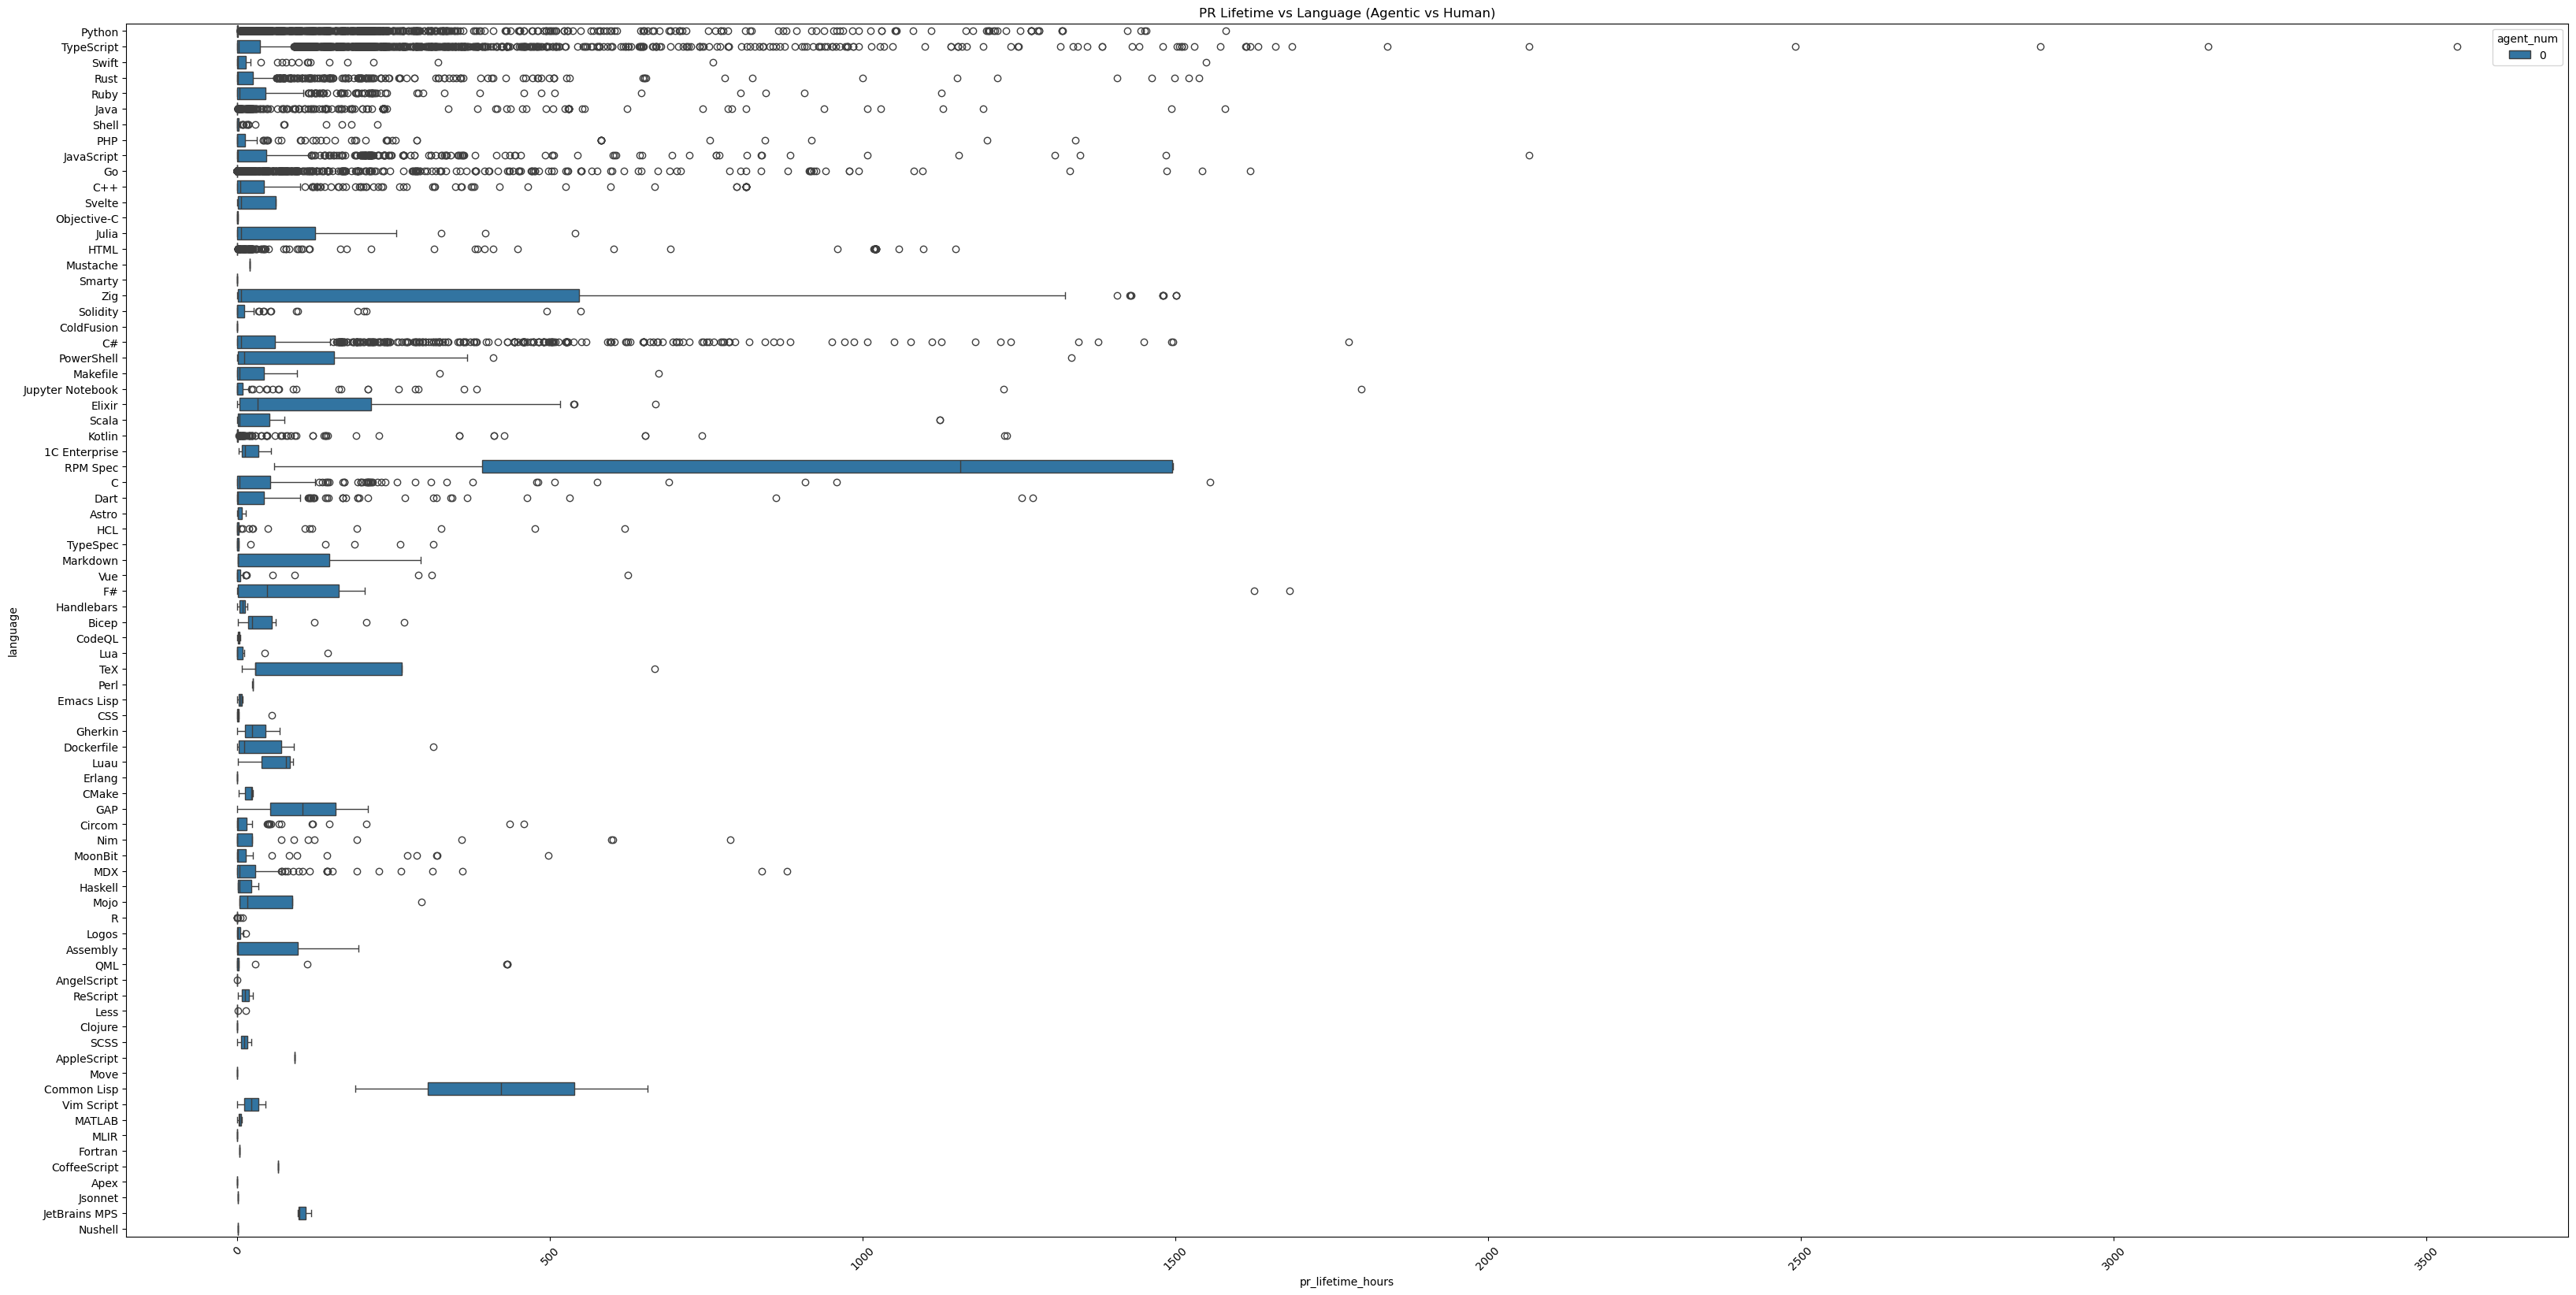

In [25]:
# making graphs
## PR Lifetime
plt.figure(figsize=(40,20))
sns.boxplot(data=merged,
            x="pr_lifetime_hours",
            y="language",
            hue="agent_num")
plt.xticks(rotation=45)
plt.title("PR Lifetime vs Language (Agentic vs Human)")
plt.savefig("PR_Lifetime.png", dpi=300, bbox_inches='tight')
plt.show()

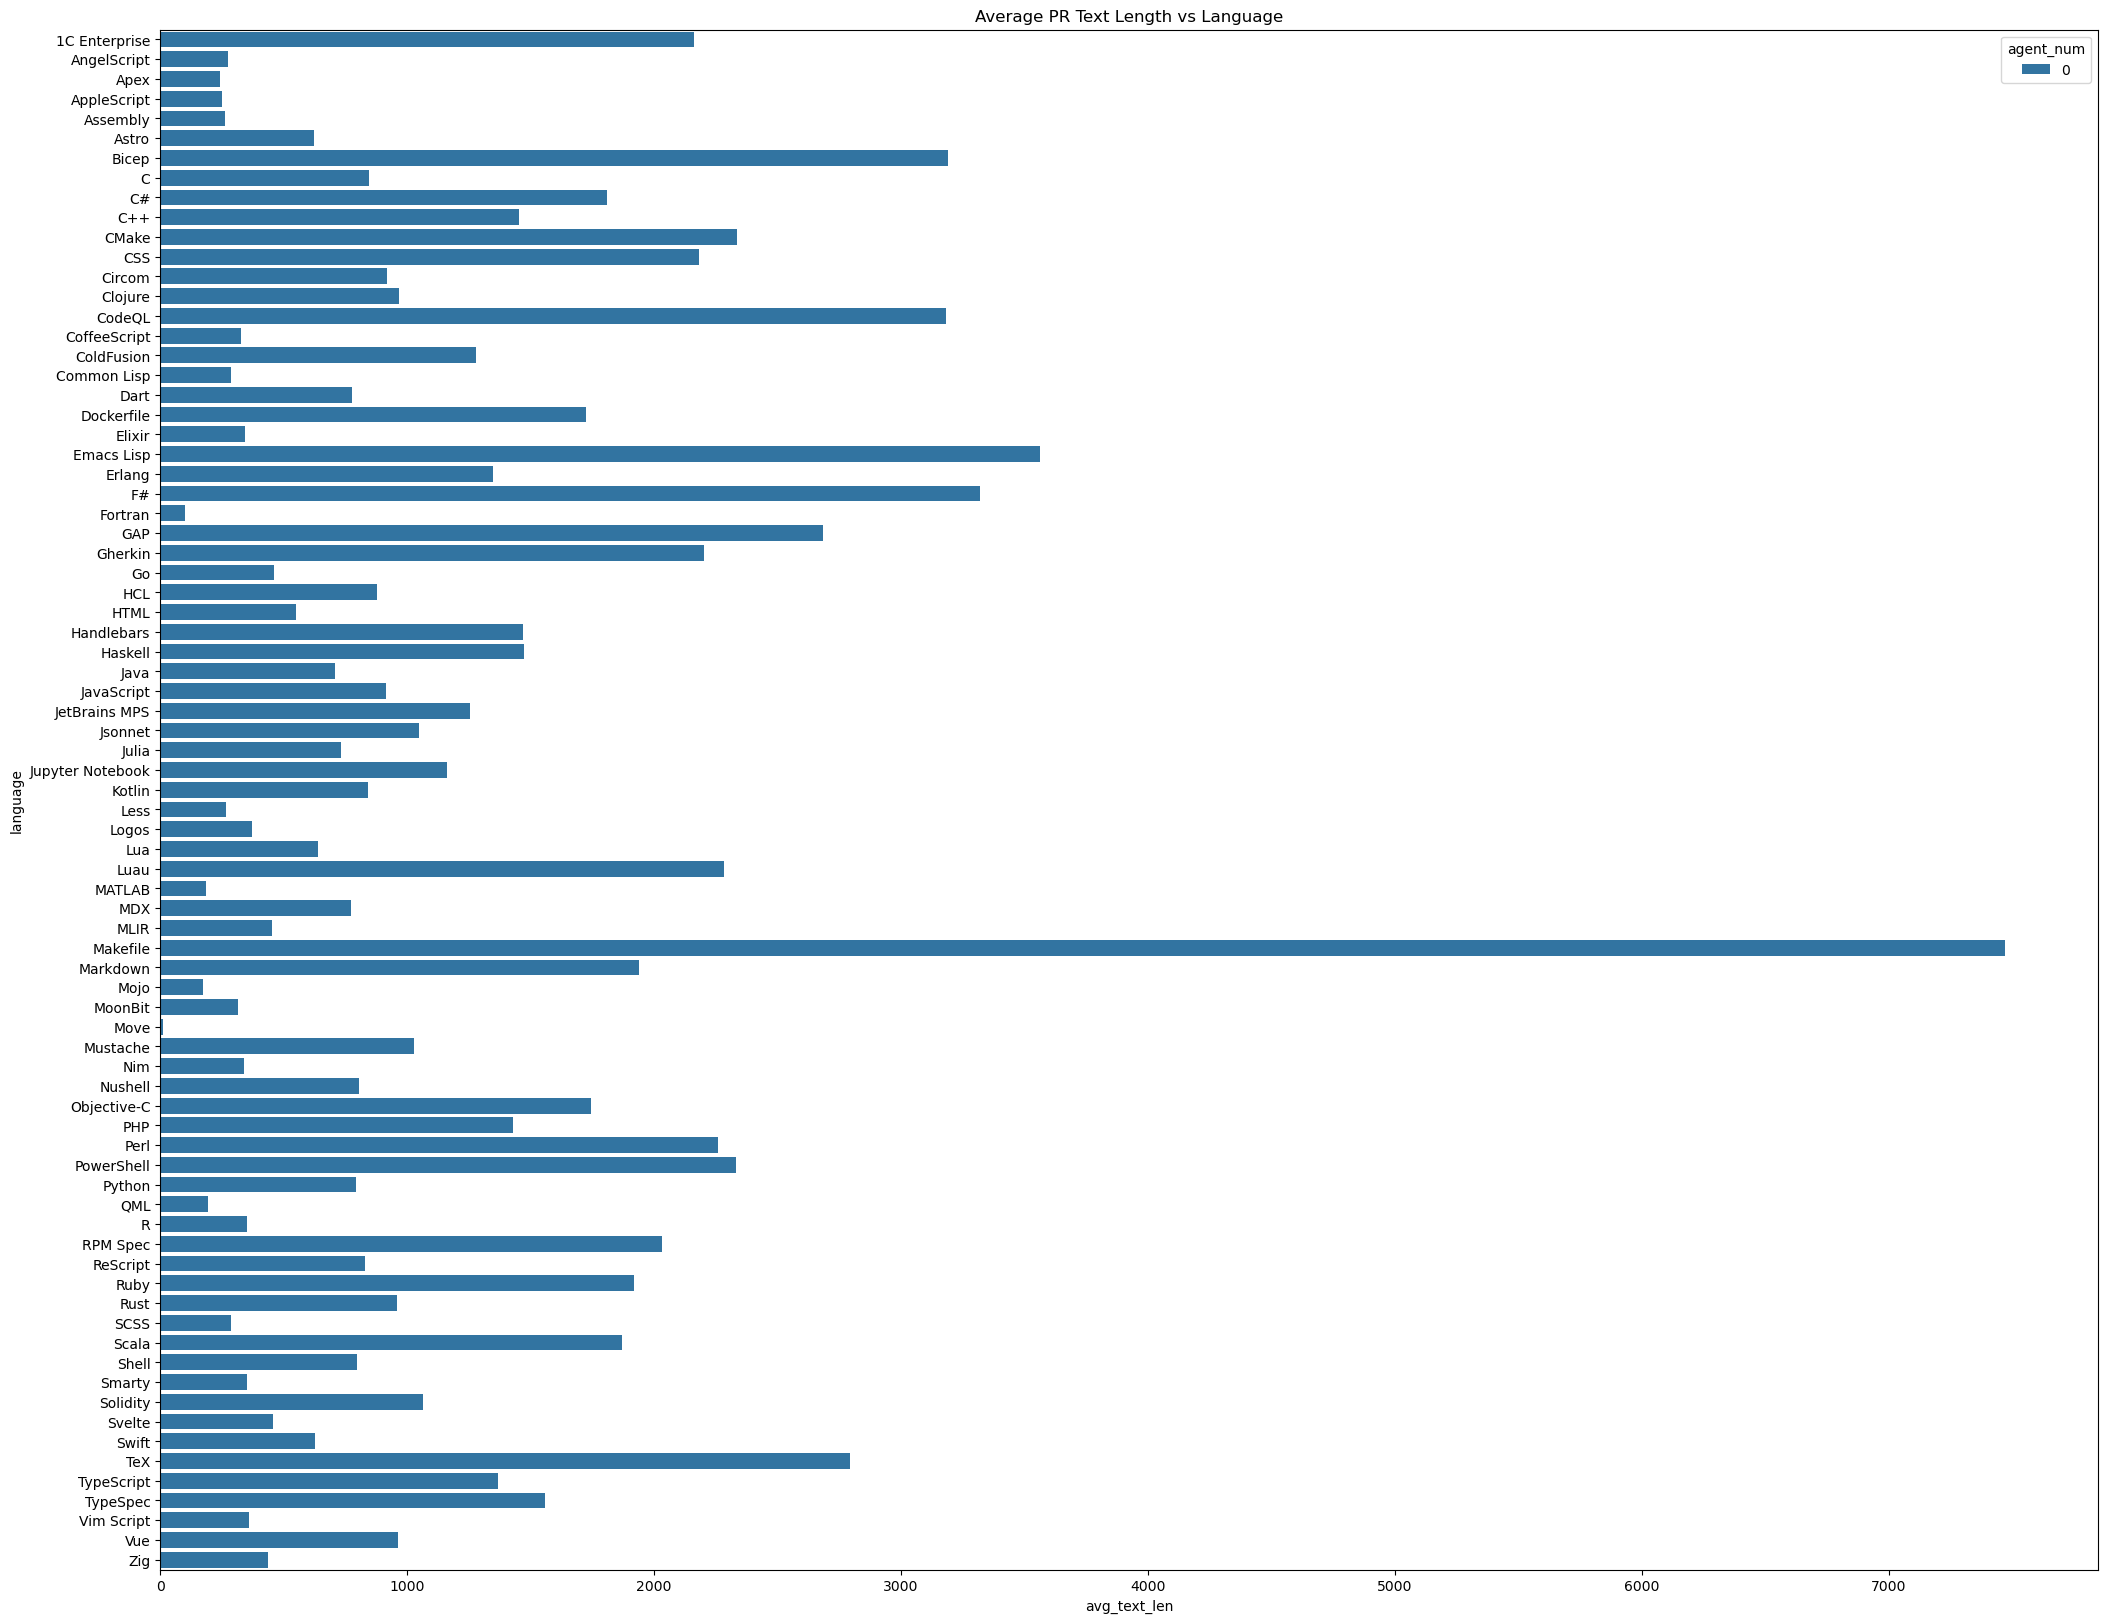

In [26]:
# Time complexity
plt.figure(figsize=(25,20))
sns.barplot(data=stats,
            x="avg_text_len",
            y="language",
            hue="agent_num")
plt.title("Average PR Text Length vs Language")
plt.savefig("Time_Complexity.png", dpi=300, bbox_inches='tight')
plt.show()

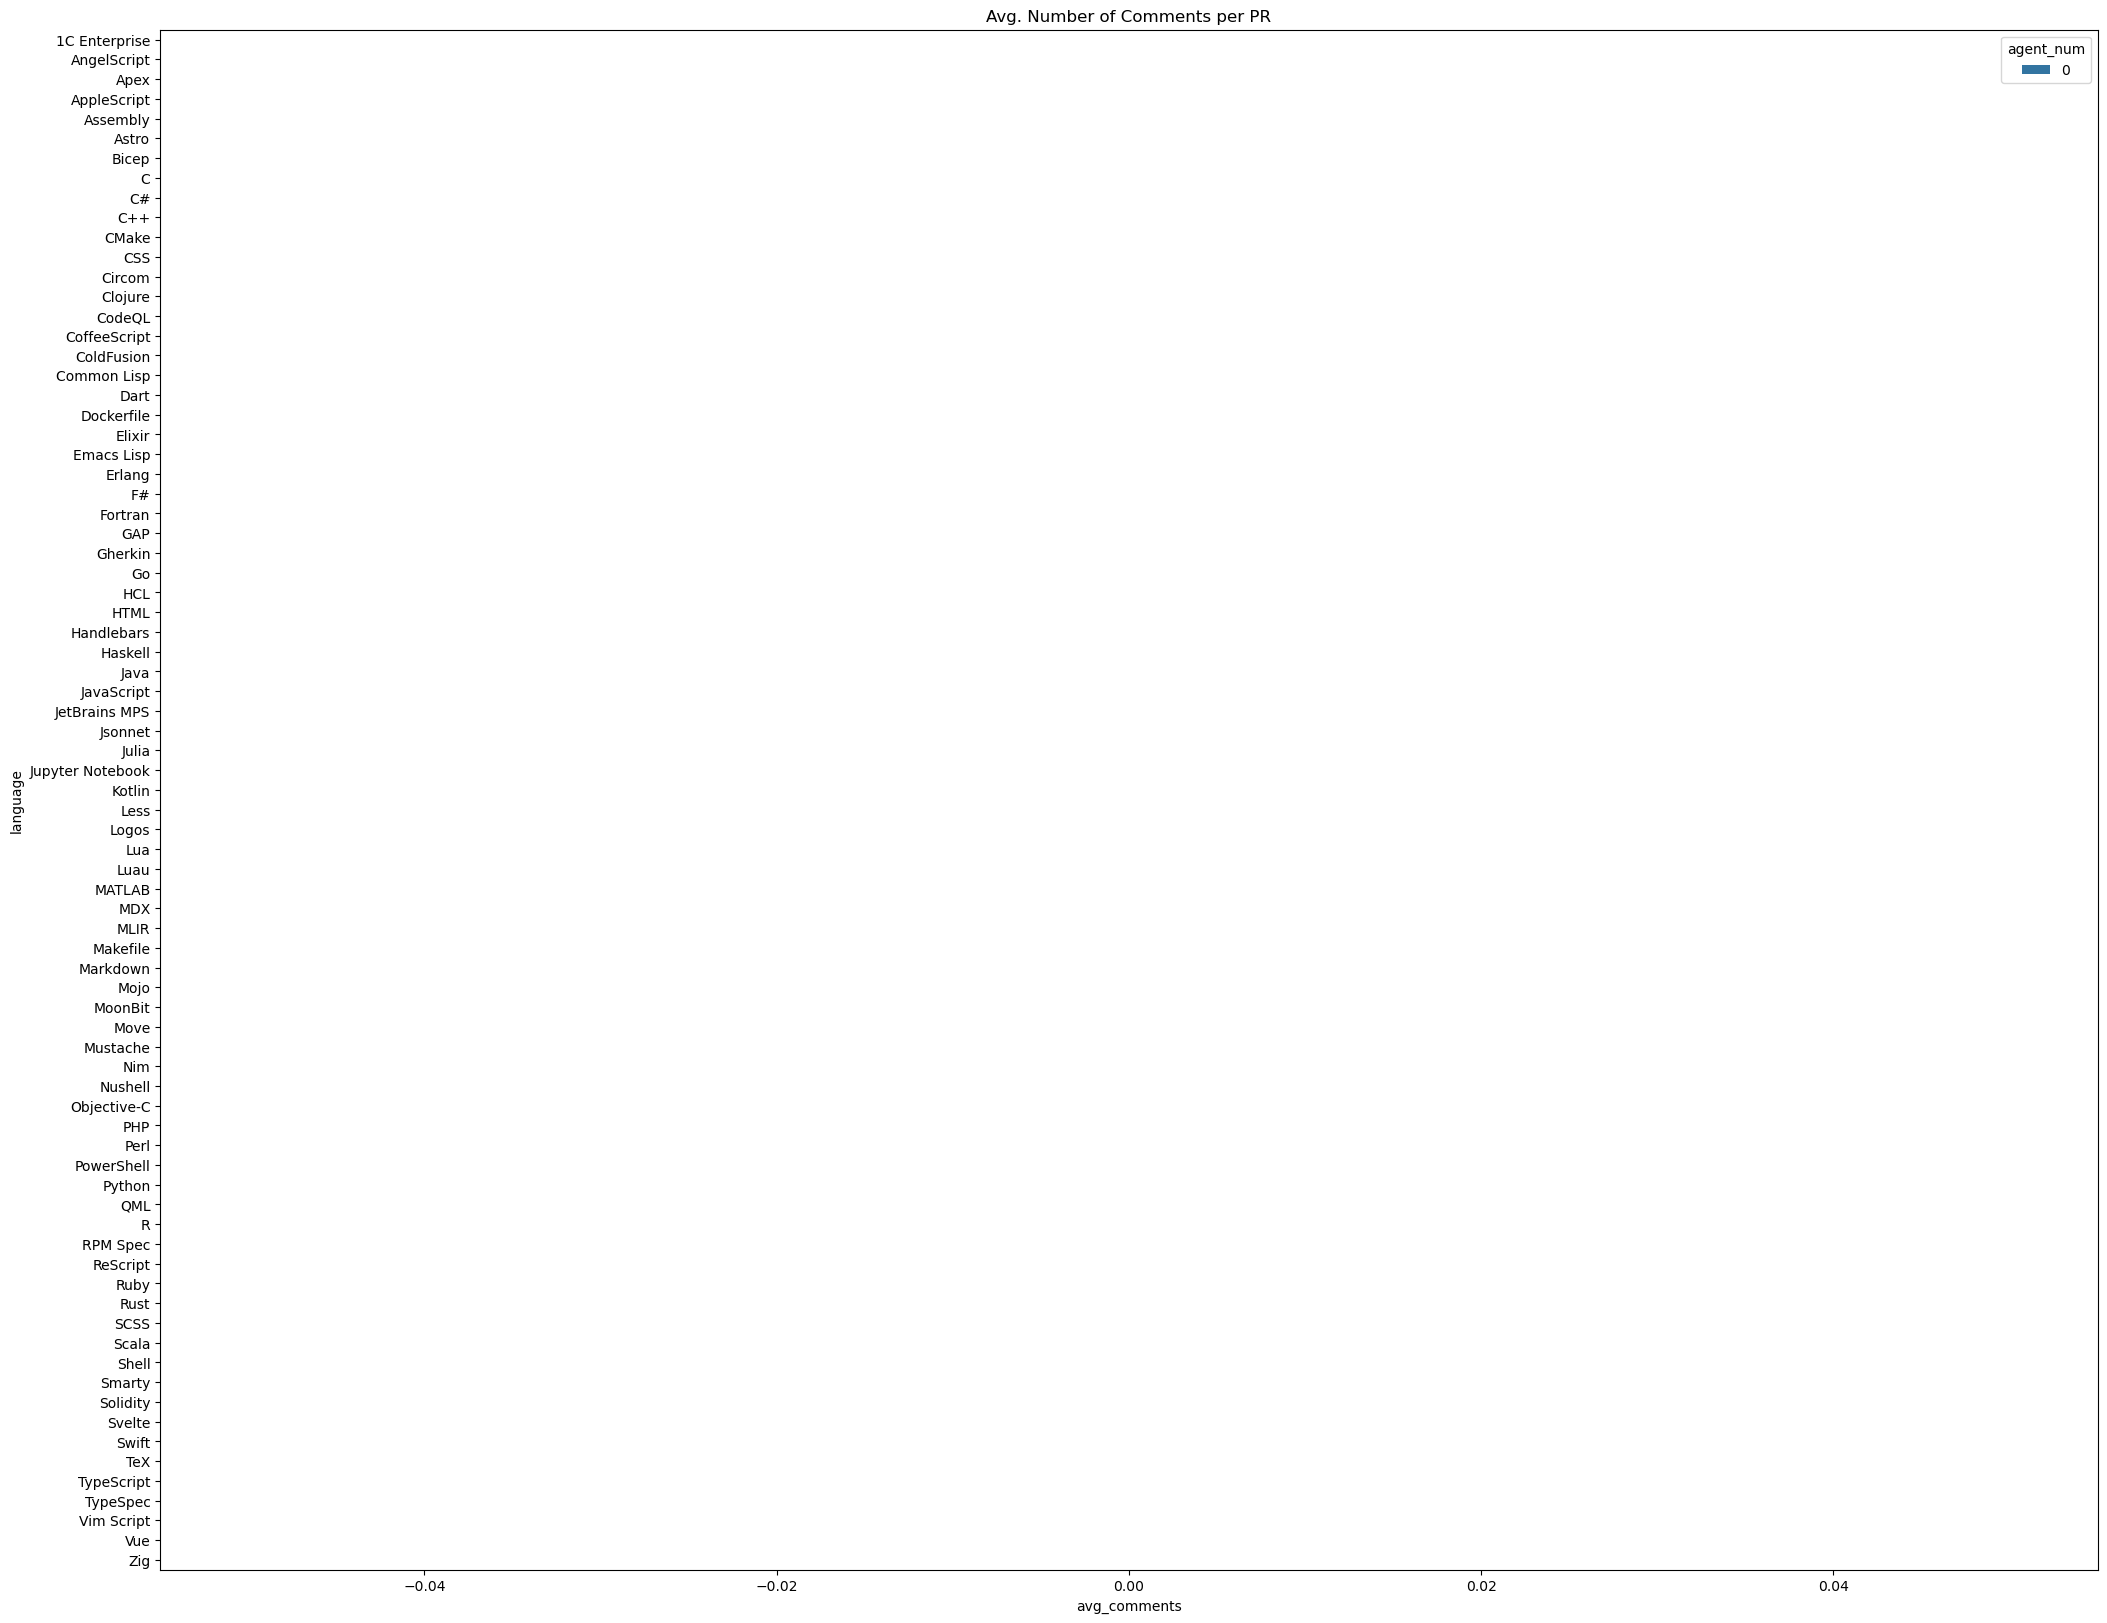

In [27]:
# Comments
plt.figure(figsize=(25,20))
sns.barplot(data=stats,
            x="avg_comments",
            y="language",
            hue="agent_num")
plt.title("Avg. Number of Comments per PR")
plt.savefig("Comments.png", dpi=300, bbox_inches='tight')
plt.show()

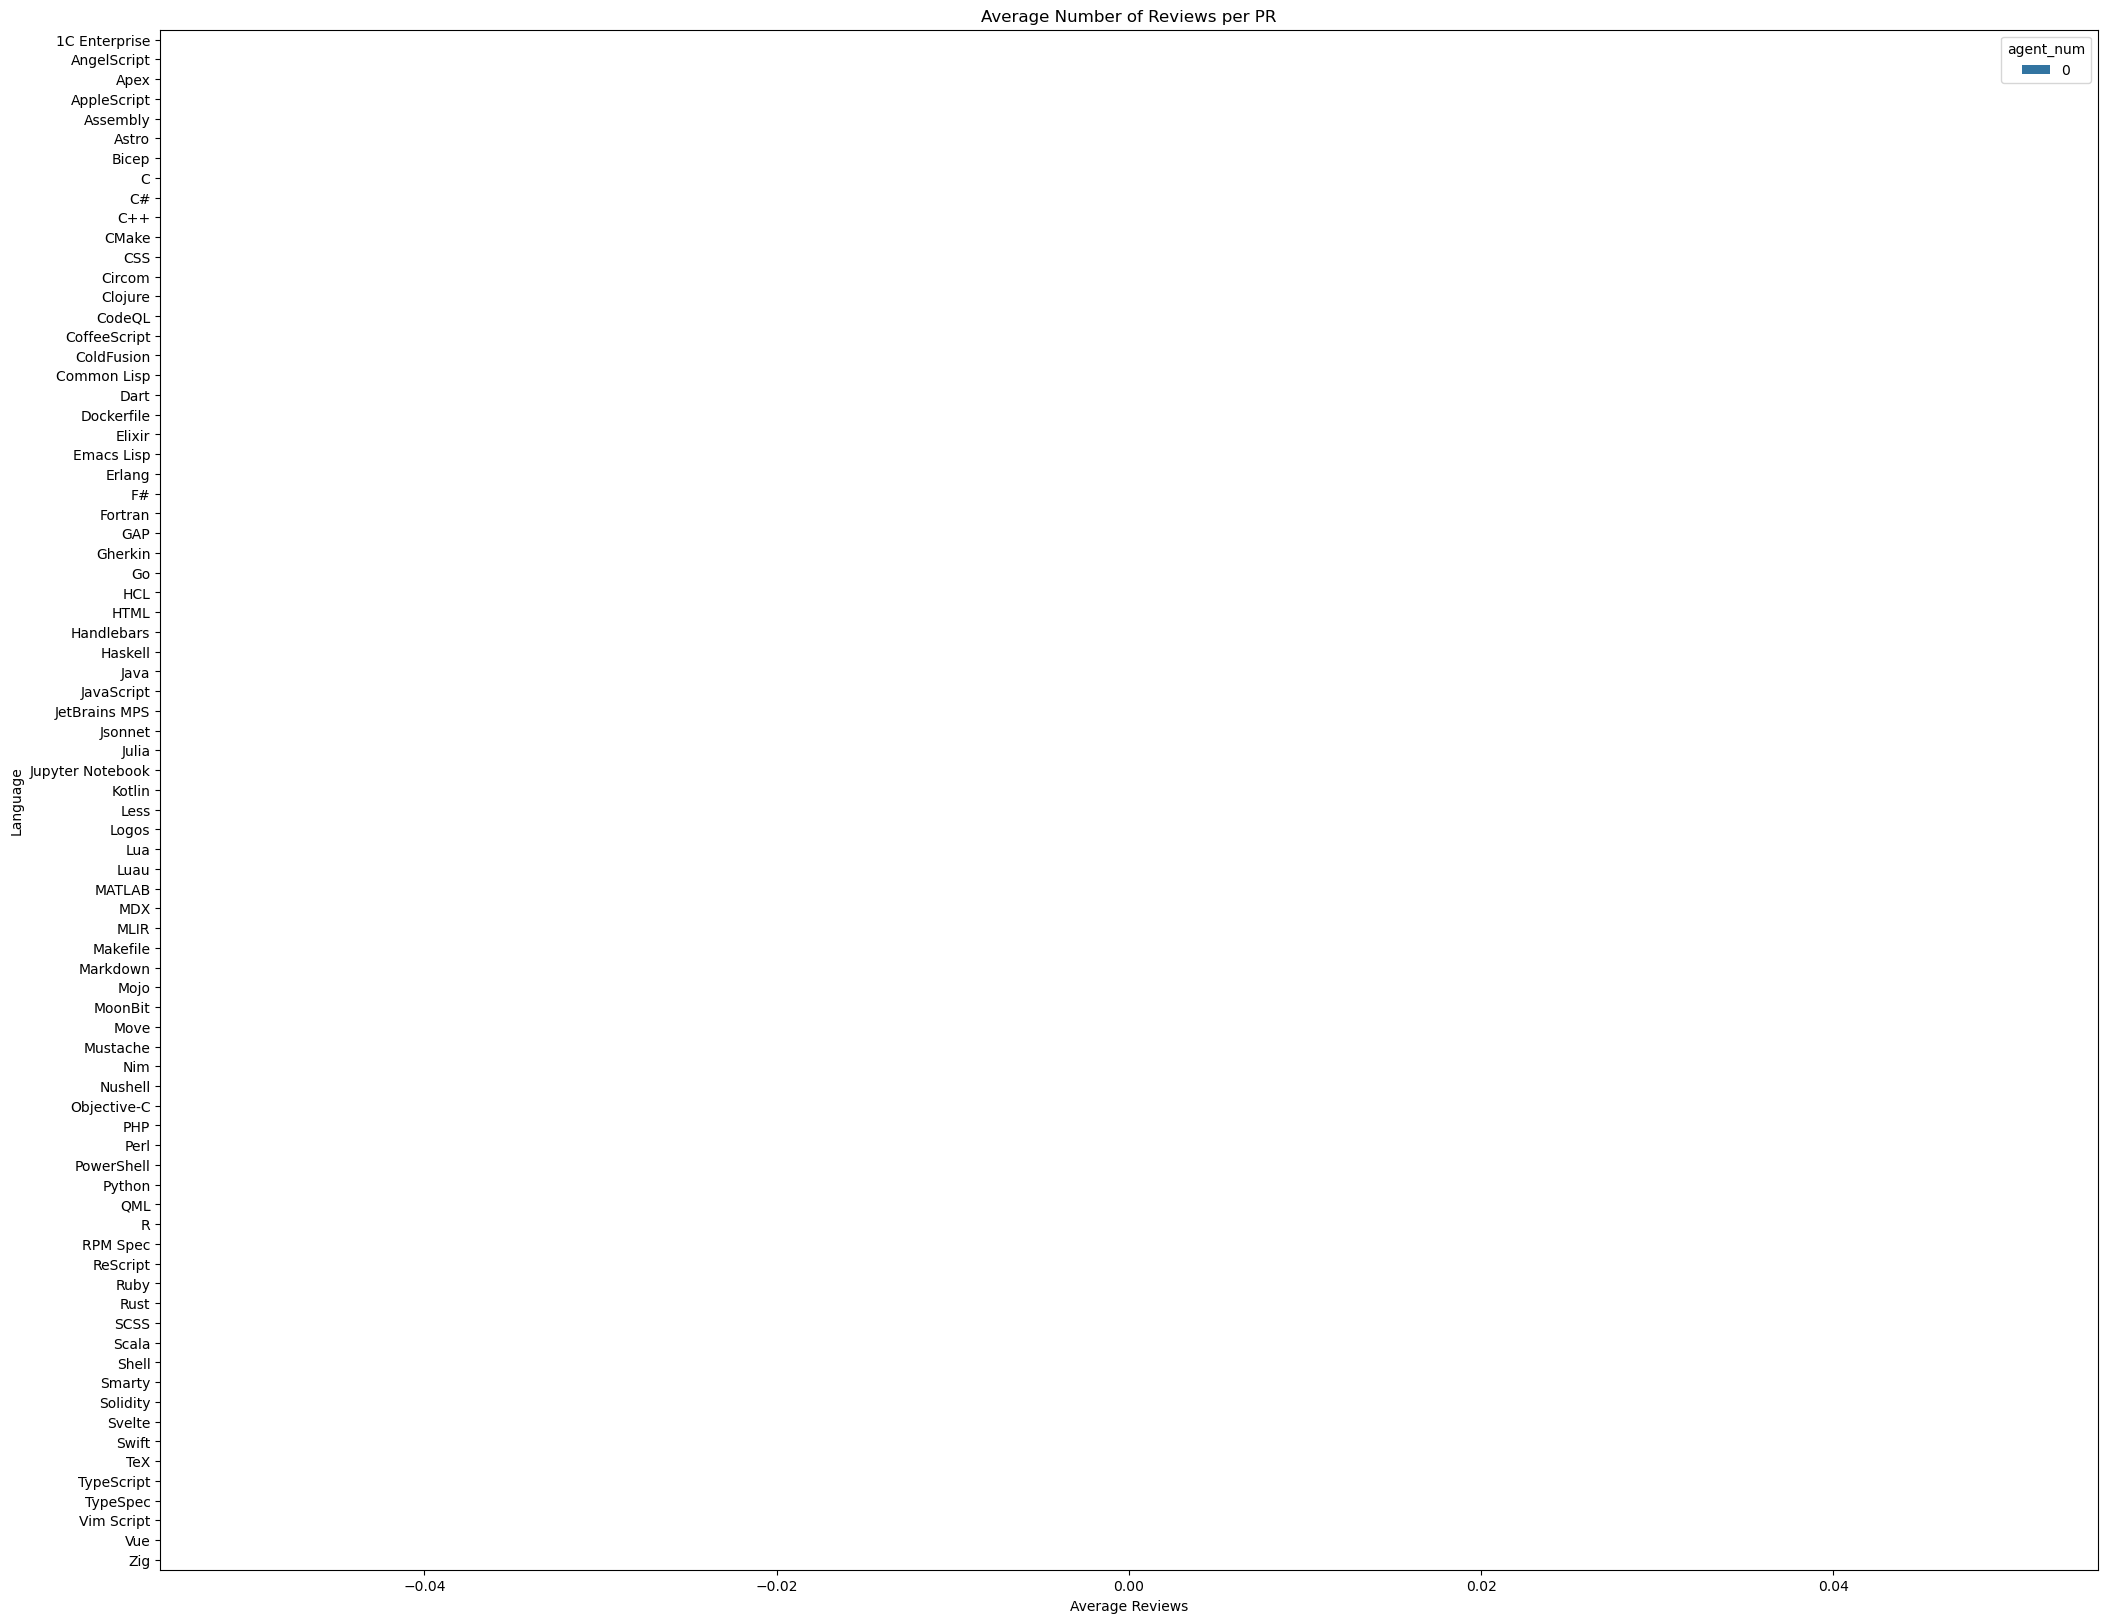

In [28]:
# Reviews

plt.figure(figsize=(25, 20)) 
sns.barplot(data=stats,
            x="avg_reviews",
            y="language",
            hue="agent_num",
           orient="h")
plt.title("Average Number of Reviews per PR")
plt.xlabel("Average Reviews")
plt.ylabel("Language")
plt.savefig("Reviews.png", dpi=300, bbox_inches='tight')
plt.show()

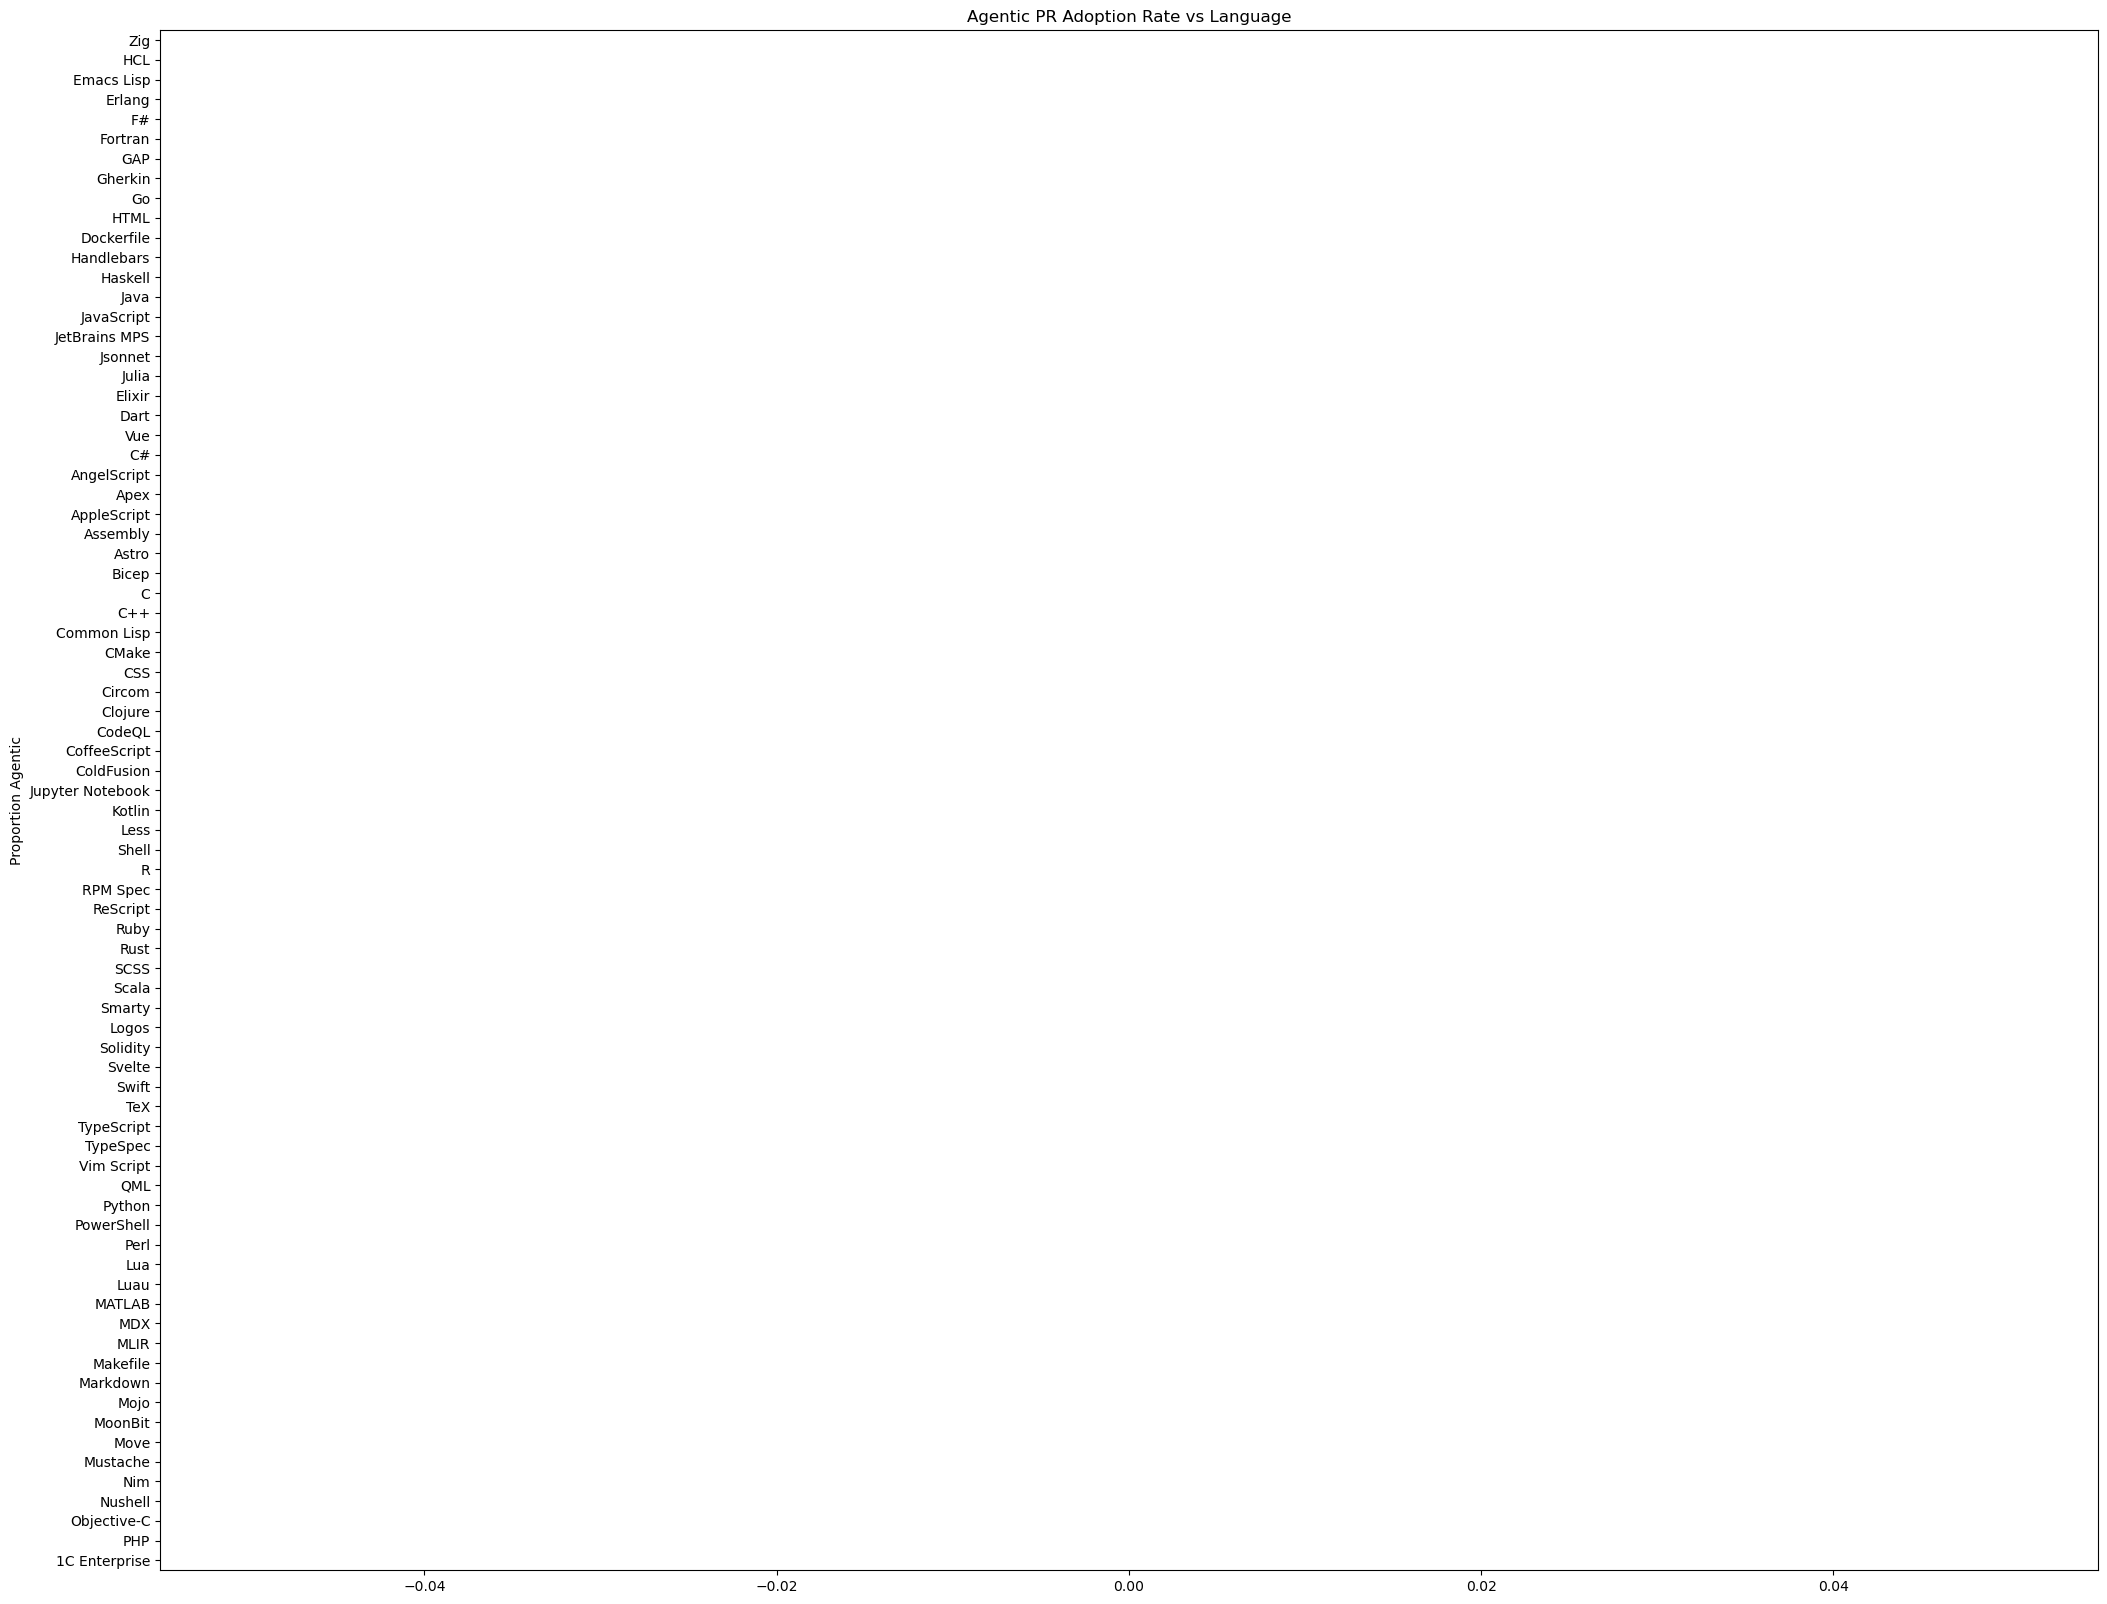

In [29]:
# Agentic Adoption rates
agentic_rate = (
    merged.groupby("language")["agent_num"]
          .mean()
          .sort_values()
)

plt.figure(figsize=(25,20))
agentic_rate.plot(kind="barh")
plt.title("Agentic PR Adoption Rate vs Language")
plt.ylabel("Proportion Agentic")
plt.savefig("Agentic_Adoption_rates.png", dpi=300, bbox_inches='tight')
plt.show()